✅ Clean numeric features retained: 109

=== Logistic Regression (Clean Inputs) ===
              precision    recall  f1-score   support

           0       0.25      0.53      0.34      7204
           1       0.95      0.84      0.89     71697

    accuracy                           0.81     78901
   macro avg       0.60      0.68      0.61     78901
weighted avg       0.88      0.81      0.84     78901

ROC-AUC: 0.7402044072014239

=== Random Forest (Clean Inputs) ===
              precision    recall  f1-score   support

           0       0.33      0.49      0.40      7204
           1       0.95      0.90      0.92     71697

    accuracy                           0.86     78901
   macro avg       0.64      0.69      0.66     78901
weighted avg       0.89      0.86      0.88     78901

ROC-AUC: 0.766398297048664

=== XGBoost (Clean Inputs) ===
              precision    recall  f1-score   support

           0       0.35      0.55      0.43      7204
           1       0.95      

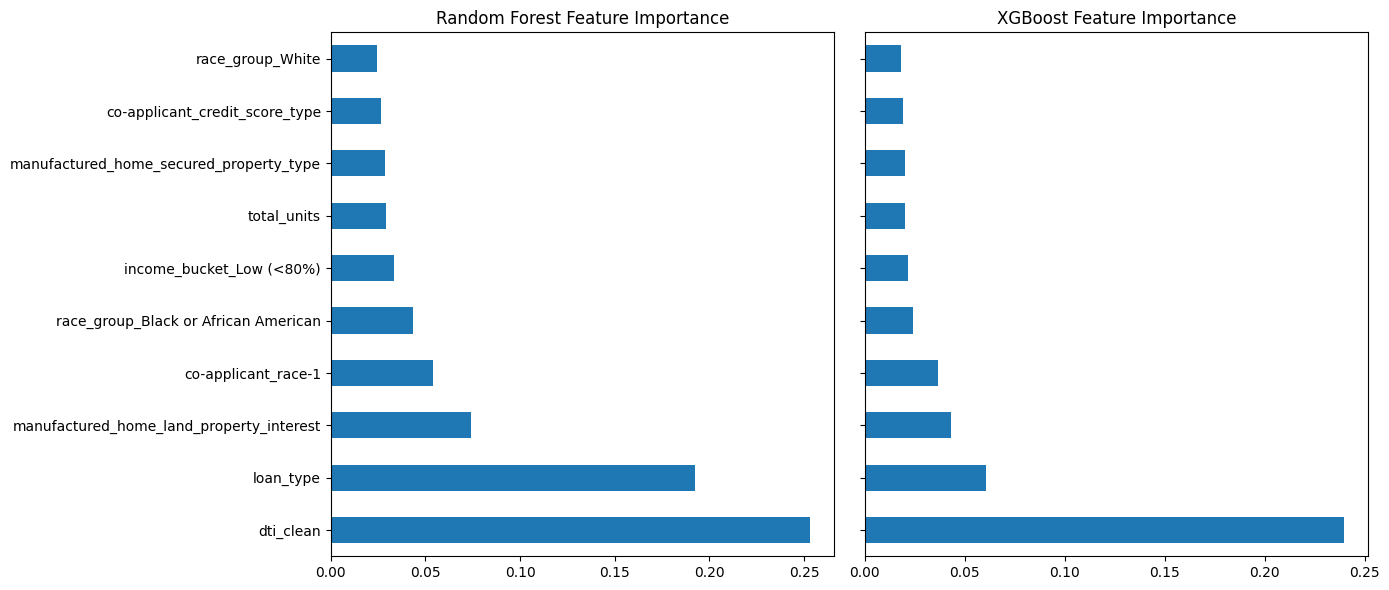

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load Data
DATA_PROCESSED = "../data/processed"
train = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv"), low_memory=False)
test = pd.read_csv(os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv"), low_memory=False)

target = "approved"

# Define Leaky or Post-Approval Variables 
leaky_vars = [
    # Outcome and post-approval
    "approved", "action_taken", "lei",
    "denial_reason_1", "denial_reason-2", "denial_reason-3",
    "hoepa_status", "purchaser_type",

    # Pricing variables
    "interest_rate", "rate_spread", "origination_charges",
    "total_points_and_fees", "total_loan_costs", "discount_points",
    "lender_credits",

    # Post-origination or label-related
    "initially_payable_to_institution", "preapproval",
    "interest_only_payment", "negative_amortization",
    "balloon_payment", "other_nonamortizing_features", "intro_rate_period",

    # Location identifiers (not relevant for fairness)
    "state_code", "county_code", "census_tract",

    "aus-1", "submission_of_application"
]

# Remove columns starting with known leaky prefixes
drop_cols = [
    c for c in train.columns
    if any(c.startswith(p) for p in ["purch_", "denial_reason_"]) or c in leaky_vars
]

# Define Predictors and Target 
X_train = train.drop(columns=[c for c in drop_cols if c in train.columns], errors="ignore")
y_train = train[target]

X_test = test.drop(columns=[c for c in drop_cols if c in test.columns], errors="ignore")
y_test = test[target]

# Clean and Convert to Numeric 
def to_numeric_df(df, ref_cols=None):
    """Convert to numeric, align to reference columns if provided."""
    df_num = df.apply(pd.to_numeric, errors="coerce")  # non-numeric -> NaN
    df_num = df_num.dropna(axis=1, how="all")
    if ref_cols is not None:
        df_num = df_num.reindex(columns=ref_cols, fill_value=np.nan)
    return df_num

X_train_num = to_numeric_df(X_train)
X_test_num = to_numeric_df(X_test, ref_cols=X_train_num.columns)

print(f"✅ Clean numeric features retained: {len(X_train_num.columns)}")

# Impute Missing Values and Scale 
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_num)
X_test_imp = imputer.transform(X_test_num)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Logistic Regression (Balanced) 
log_clf = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
log_clf.fit(X_train_scaled, y_train)

y_pred_log = log_clf.predict(X_test_scaled)
y_prob_log = log_clf.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression (Clean Inputs) ===")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# Random Forest 
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_imp, y_train)  # use imputed numeric (not scaled)
y_pred_rf = rf_clf.predict(X_test_imp)
y_prob_rf = rf_clf.predict_proba(X_test_imp)[:, 1]

print("\n=== Random Forest (Clean Inputs) ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# XGBoost 
xgb_clf = XGBClassifier(
    n_estimators=250,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42,
    n_jobs=-1,
    eval_metric="auc"
)
xgb_clf.fit(X_train_imp, y_train)
y_pred_xgb = xgb_clf.predict(X_test_imp)
y_prob_xgb = xgb_clf.predict_proba(X_test_imp)[:, 1]

print("\n=== XGBoost (Clean Inputs) ===")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

# Plot Feature Importance 
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Random Forest
rf_imp = pd.Series(rf_clf.feature_importances_, index=X_train_num.columns).nlargest(10)
rf_imp.plot(kind="barh", ax=axes[0], title="Random Forest Feature Importance")

# XGBoost
xgb_imp = pd.Series(xgb_clf.feature_importances_, index=X_train_num.columns).nlargest(10)
xgb_imp.plot(kind="barh", ax=axes[1], title="XGBoost Feature Importance")

plt.tight_layout()
plt.show()


=== Approval Rates by Race Group ===
race_group_original
American Indian or Alaska Native    0.783
Asian                               0.863
Black or African American           0.649
Hispanic or Latino                  0.805
Pacific Islander                    0.772
White                               0.876
Name: y_pred, dtype: float64

=== Disparate Impact Ratios (vs White) ===
race_group_original
American Indian or Alaska Native    0.893
Asian                               0.985
Black or African American           0.741
Hispanic or Latino                  0.919
Pacific Islander                    0.882
White                               1.000
Name: y_pred, dtype: float64

=== Error Rates by Race Group ===
                                    FNR    FPR
race_group_original                           
American Indian or Alaska Native  0.143  0.333
Asian                             0.094  0.461
Black or African American         0.296  0.303
Hispanic or Latino                0.149  0.406

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_91821/250947621.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  error_rates = test_with_preds.groupby("race_group_original", group_keys=False).apply(compute_error_rates)


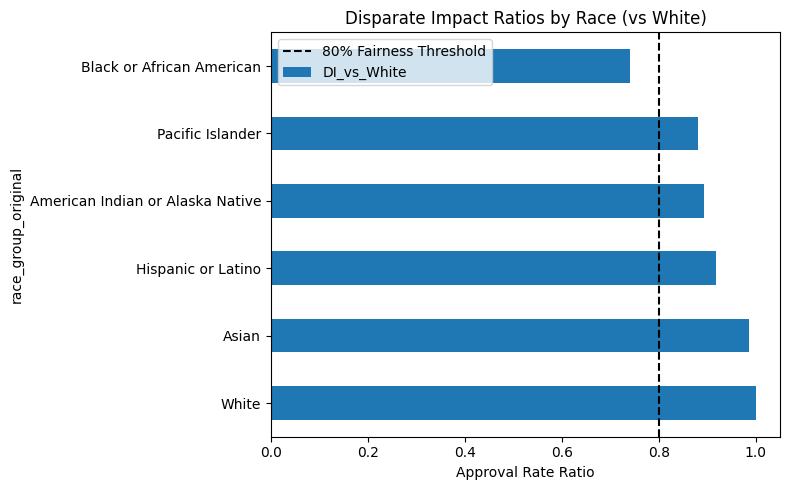

⚠️ Potential disparate impact detected (lowest ratio: 0.74)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure we have predictions 
test_with_preds = test.copy()
test_with_preds["y_pred"] = y_pred_xgb
test_with_preds["y_prob"] = y_prob_xgb

# Approval Rates by Race 
approval_rates = test_with_preds.groupby("race_group_original")["y_pred"].mean()
white_rate = approval_rates.get("White", np.nan)
disparate_impact = approval_rates / white_rate

print("\n=== Approval Rates by Race Group ===")
print(approval_rates.round(3))

print("\n=== Disparate Impact Ratios (vs White) ===")
print(disparate_impact.round(3))

# Error Rates by Race Group 
def compute_error_rates(df):
    tn, fp, fn, tp = confusion_matrix(df["approved"], df["y_pred"]).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    return pd.Series({"FNR": fnr, "FPR": fpr})

error_rates = test_with_preds.groupby("race_group_original", group_keys=False).apply(compute_error_rates)

print("\n=== Error Rates by Race Group ===")
print(error_rates.round(3))

# Combine into One Summary Table 
fairness_summary = pd.concat([approval_rates, disparate_impact, error_rates], axis=1)
fairness_summary.columns = ["ApprovalRate", "DI_vs_White", "FNR", "FPR"]
print("\n=== Fairness Summary ===")
print(fairness_summary.round(3))

# Visualize Disparate Impact 
plt.figure(figsize=(8, 5))
fairness_summary["DI_vs_White"].sort_values(ascending=False).plot(
    kind="barh"
)
plt.axvline(0.8, color="black", linestyle="--", label="80% Fairness Threshold")
plt.title("Disparate Impact Ratios by Race (vs White)")
plt.xlabel("Approval Rate Ratio")
plt.legend()
plt.tight_layout()
plt.show()

# Fairness Diagnostic Notes 
min_ratio = fairness_summary["DI_vs_White"].min()
if min_ratio < 0.8:
    print(f"⚠️ Potential disparate impact detected (lowest ratio: {min_ratio:.2f})")
else:
    print("✅ No major disparate impact (all ratios ≥ 0.80).")

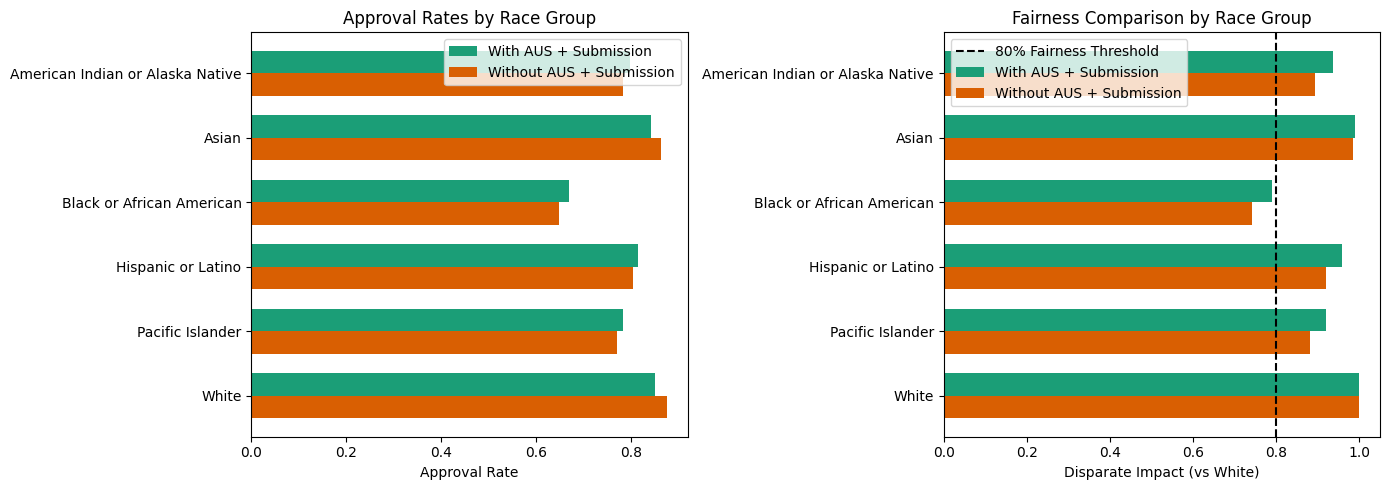

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


with_controls = pd.DataFrame({
    "ApprovalRate": {
        "American Indian or Alaska Native": 0.798,
        "Asian": 0.842,
        "Black or African American": 0.671,
        "Hispanic or Latino": 0.815,
        "Pacific Islander": 0.783,
        "White": 0.851,
    },
    "DI_vs_White": {
        "American Indian or Alaska Native": 0.938,
        "Asian": 0.990,
        "Black or African American": 0.789,
        "Hispanic or Latino": 0.958,
        "Pacific Islander": 0.920,
        "White": 1.000,
    }
})

without_controls = pd.DataFrame({
    "ApprovalRate": {
        "American Indian or Alaska Native": 0.783,
        "Asian": 0.863,
        "Black or African American": 0.649,
        "Hispanic or Latino": 0.805,
        "Pacific Islander": 0.772,
        "White": 0.876,
    },
    "DI_vs_White": {
        "American Indian or Alaska Native": 0.893,
        "Asian": 0.985,
        "Black or African American": 0.741,
        "Hispanic or Latino": 0.919,
        "Pacific Islander": 0.882,
        "White": 1.000,
    }
})

# Plot setup 
groups = with_controls.index
x = np.arange(len(groups))
bar_width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ["#1b9e77", "#d95f02"]

# Approval Rates Comparison 
axes[0].barh(x - bar_width/2, with_controls["ApprovalRate"], bar_width, label="With AUS + Submission", color=colors[0])
axes[0].barh(x + bar_width/2, without_controls["ApprovalRate"], bar_width, label="Without AUS + Submission", color=colors[1])
axes[0].set_yticks(x)
axes[0].set_yticklabels(groups)
axes[0].invert_yaxis()
axes[0].set_xlabel("Approval Rate")
axes[0].set_title("Approval Rates by Race Group")
axes[0].legend()

# Disparate Impact Comparison 
axes[1].barh(x - bar_width/2, with_controls["DI_vs_White"], bar_width, label="With AUS + Submission", color=colors[0])
axes[1].barh(x + bar_width/2, without_controls["DI_vs_White"], bar_width, label="Without AUS + Submission", color=colors[1])
axes[1].axvline(0.8, color="black", linestyle="--", label="80% Fairness Threshold")
axes[1].set_yticks(x)
axes[1].set_yticklabels(groups)
axes[1].invert_yaxis()
axes[1].set_xlabel("Disparate Impact (vs White)")
axes[1].set_title("Fairness Comparison by Race Group")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:

import pandas as pd
import numpy as np
import requests
from sklearn.metrics import confusion_matrix, roc_auc_score

# Helper Function: Compute Fairness Summary 
def compute_fairness_summary(test_df, pred_col, race_col="race_group_original", y_true_col="approved"):
    approval_rates = test_df.groupby(race_col)[pred_col].mean()
    white_rate = approval_rates.get("White", np.nan)
    di_ratios = approval_rates / white_rate

    # Compute error rates safely (handle single-class cases)
    error_stats = []
    for group, subset in test_df.groupby(race_col):
        try:
            tn, fp, fn, tp = confusion_matrix(subset[y_true_col], subset[pred_col], labels=[0, 1]).ravel()
        except ValueError:
            tn = fp = fn = tp = np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        error_stats.append([group, fnr, fpr])

    error_rates = pd.DataFrame(error_stats, columns=[race_col, "FNR", "FPR"]).set_index(race_col)

    summary = f"=== Approval Rates by Race Group ===\n{approval_rates.round(3).to_string()}\n\n"
    summary += f"=== Disparate Impact Ratios (vs White) ===\n{di_ratios.round(3).to_string()}\n\n"
    summary += f"=== Error Rates (FNR / FPR) ===\n{error_rates.round(3).to_string()}\n"
    return summary


# Generate Fairness Summaries for Each Model 
fairness_summaries = {}

# Logistic Regression
test_with_preds_log = test.copy()
test_with_preds_log["y_pred_log"] = y_pred_log
fairness_summaries["Logistic Regression"] = compute_fairness_summary(test_with_preds_log, "y_pred_log")

# XGBoost
test_with_preds_xgb = test.copy()
test_with_preds_xgb["y_pred_xgb"] = y_pred_xgb
fairness_summaries["XGBoost"] = compute_fairness_summary(test_with_preds_xgb, "y_pred_xgb")

# Combine all fairness summaries
combined_summary = "\n\n---\n\n".join(
    [f"### {name} ###\n{summary}" for name, summary in fairness_summaries.items()]
)

print("✅ Generated fairness summaries for both models.\n")
print(combined_summary)


# Load API Key (from secure text file) 
try:
    with open("API_KEY.txt", "r") as file:
        API_KEY = file.read().replace("\n", "").strip()
except FileNotFoundError:
    raise FileNotFoundError("❌ Missing API_KEY.txt file. Please save your OpenRouter key in the project folder.")


# Define API and Model 
api_url = "https://openrouter.ai/api/v1/chat/completions"
model = "openai/gpt-4o-mini"

# Define System Message (Ethics Officer Persona) 
system_message = """
You are an AI Ethics Officer designed to analyze fairness, bias, and systemic risk in automated decision systems.

Ethical foundation:
• Respect for Persons — protect autonomy, consent, and dignity.
• Beneficence — maximize benefits, minimize harm.
• Justice — ensure fair distribution of risks and rewards.

Philosophical anchor: Kantian duty ethics — uphold principles even when outcomes are uncertain,
and never treat people as tools. Respond as if briefing a policy audience — clear, grounded, and ethically informed.
"""

# Provide Context and Feature Information 
features_summary = """
Model setup:
- Target: approved (1 = approved, 0 = denied)
- Data: 2022 California HMDA (265k clean loans)
- Train/test split: 70/30, stratified by approval outcome
- Excluded leakage variables: interest_rate, rate_spread, denial_reason_*, purchaser_*, hoepa_status, etc.

Key features:
- income_ratio: borrower income relative to loan size
- loan_to_value_ratio: how leveraged the borrower is
- dti_clean: debt-to-income ratio
- loan_term, occupancy_type, property_value, total_units
- co_applicant_* demographic fields
- race_group_* indicators (White as baseline)

Top features (XGBoost importance):
dti_clean, income_ratio, loan_to_value_ratio, co_applicant_race_observed
"""

context_note = """
Context:
Research by William Apgar et al. (Harvard JCHS, 2007) found that the mortgage market is segmented,
with African-American and Hispanic borrowers more likely to receive loans through less-regulated,
higher-priced channels — often outside CRA oversight. These structural patterns may contribute to
observed approval and pricing disparities, even when controlling for credit risk factors.
"""

# Optionally compute model ROC-AUCs if available
try:
    roc_auc_log = roc_auc_score(test["approved"], y_prob_log)
    roc_auc_xgb = roc_auc_score(test["approved"], y_prob_xgb)
    perf_summary = f"""
Model Performance:
- Logistic Regression ROC-AUC: {roc_auc_log:.3f}
- XGBoost ROC-AUC: {roc_auc_xgb:.3f}
"""
except Exception:
    perf_summary = "(Performance metrics unavailable in this run.)"

# Combine Prompt for LLM Ethics Review 
prompt_content = f"""
{features_summary}

{context_note}

{perf_summary}

Here are fairness metrics from two mortgage approval models (Logistic Regression and XGBoost):

{combined_summary}

Please provide a structured analysis using the Belmont Report principles:
- Respect for Persons
- Beneficence
- Justice

Also include System 1 (fast detector) and System 2 (slow adjudicator) reasoning,
linking patterns in the data to potential systemic causes and governance implications.
"""

# Prepare API Payload 
payload = {
    "model": model,
    "messages": [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt_content},
    ],
    "temperature": 0.4,
}

headers = {
    "Authorization": f"Bearer {API_KEY}",
    "HTTP-Referer": "https://localhost",  # Required header for OpenRouter
    "X-Title": "Mortgage Fairness Ethics Analysis",
}

# Make API Request 
response = requests.post(api_url, headers=headers, json=payload)

# Handle Response 
if response.status_code == 200:
    result = response.json()
    output = result["choices"][0]["message"]["content"]

    print("\n=== GPT Comparative Fairness Analysis ===\n")
    print(output)

    # Save both prompt and result for audit trail
    with open("fairness_prompt_context.txt", "w") as f:
        f.write(prompt_content)
    with open("fairness_comparison_summary.txt", "w") as f:
        f.write(output)

    print("\n📝 Saved outputs to fairness_prompt_context.txt and fairness_comparison_summary.txt")

else:
    print(f"❌ Error {response.status_code}: {response.text}")

✅ Generated fairness summaries for both models.

### Logistic Regression ###
=== Approval Rates by Race Group ===
race_group_original
American Indian or Alaska Native    0.806
Asian                               0.813
Black or African American           0.503
Hispanic or Latino                  0.714
Pacific Islander                    0.704
White                               0.830

=== Disparate Impact Ratios (vs White) ===
race_group_original
American Indian or Alaska Native    0.971
Asian                               0.979
Black or African American           0.605
Hispanic or Latino                  0.859
Pacific Islander                    0.848
White                               1.000

=== Error Rates (FNR / FPR) ===
                                    FNR    FPR
race_group_original                           
American Indian or Alaska Native  0.157  0.583
Asian                             0.152  0.485
Black or African American         0.459  0.266
Hispanic or Latino            